In [1]:
# Import general data analysis tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.colors as colors
from itertools import combinations
from scipy.stats import spearmanr
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

saveDir = os.getcwd()

# ---- Plotly Import ---- #
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Import pickle to save the Knn models
import pickle
import joblib

# Import warnings to save warnings tool
import warnings
from pandas.core.common import SettingWithCopyWarning

C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29024\1370514729.py:11: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Load and clean langberg data
# Remove components with less than 1% data presence

In [3]:
lDf = pd. read_excel('LangbergData.xlsx')
lDf.columns = lDf.iloc[0]
cols = lDf.columns.to_list()
lDf = lDf.drop(0, axis = 0)
lDf = lDf.drop(lDf.columns[[0,1,4,5,7,9,10]], axis=1)
lDf = lDf.replace(to_replace='<', value=0, regex=True)
lDf = lDf.fillna(0)

df2 = lDf[lDf.columns.to_list()[0:4]]
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
    for i in lDf.columns.to_list()[4:len(lDf.columns)]:
        s = lDf[i]
        val = len(s[s > 0])/len(s)
        if val >= 0.01:
            df2[i] = list(s)


In [4]:
plt.close()
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
    col1 = 'Sum LC-PFCA'
    col2 = 'Sum PFSA'
    lDf[col1] = lDf[['PFHpA','PFOA','PFNA','PFDA','PFUnDA','PFDoDA','PFTrDA','PFTeDA','PFPeDA']].sum(axis=1)
    # lDf[col1] = lDf['PFUnDA']
    lDf[col2] = lDf[['PFHxS','PFHpS','L-PFOS','Br-PFOS','PFDS']].sum(axis=1)
    lDf = lDf[(lDf[col1] > 0) | (lDf[col2] > 0)]
    # ---This is where removal of zeros with 1/10 MDL ---#
    lDf.loc[lDf['Tissue'].str.strip() == 'Liver', [col1,col2]] = lDf.loc[lDf['Tissue'].str.strip() == 'Liver', [col1,col2]].replace(0, 0.05)
    lDf.loc[lDf['Tissue'].str.strip() == 'Muscle', [col1,col2]] = lDf.loc[lDf['Tissue'].str.strip() == 'Muscle', [col1,col2]].replace(0, 0.01)

    df3 = lDf
    Liv = df3[df3['Tissue'] == 'Liver']
    Mus = df3[df3['Tissue'] == 'Muscle']

    # ---This is where log transform happens ---#
    lX = np.log10(Liv[[col1, col2]].to_numpy())
    mX = np.log10(Mus[[col1, col2]].to_numpy())

    Liv['PFAS source'] = pd.Categorical(Liv['PFAS source'])
    Liv['Categories'] = Liv['PFAS source'].cat.codes
    lSc = list(Liv['PFAS source'])

    Mus['PFAS source'] = pd.Categorical(Mus['PFAS source'])
    Mus['Categories'] = Mus['PFAS source'].cat.codes
    mSc = list(Mus['PFAS source'])

    ly = Liv['Categories'].to_numpy()
    my = Mus['Categories'].to_numpy()
    print(lDf[lDf[col1] > 0.05][col1].min())


0.0518


In [7]:
def inverse(distance):
    weights=1/np.array(distance)
    weights[np.isinf(weights)] = np.nanmax(weights[~np.isinf(weights)])
    return weights
plt.rcParams['font.family'] = 'Times New Roman'


# Process Liver data based on source first - KNN

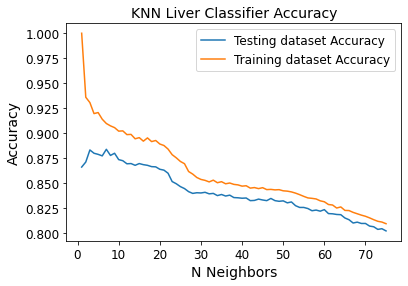

7


In [6]:
# Split into test and training
totalK = 75
totalR = 50
neighbors = np.arange(1, totalK+1)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalK, totalR))
trains = np.zeros((totalK, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                lX, ly, test_size = 0.2, random_state=j)
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(neighbors, testAvg, label = 'Testing dataset Accuracy')
plt.plot(neighbors, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('KNN Liver Classifier Accuracy', fontsize = 14)
plt.xlabel('N Neighbors', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\KNN_liver_calibration.png', dpi = 150, bbox_inches='tight')
plt.show()
print(testAvg.argmax()+1)

KNN accuracy for Liver data: 0.91
KNN Accuracy for muscle with Liver classifer: 0.48


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29024\1524571895.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFCAs'] = lX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29024\1524571895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFSAs'] = lX[:,1]


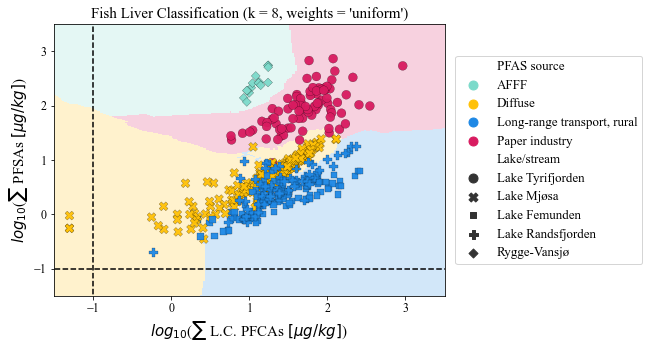

In [8]:
# Close plots at start of each block to prevent odd figure behavior
plt.close()
plt.rcParams['font.family'] = 'Times New Roman'
n_neighbors=8
knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights= 'uniform')
knn.fit(lX,ly)
acc = knn.score(lX, ly)
acc2 = knn.score(mX, my)

print("KNN accuracy for Liver data: " + str(round(acc,3)))
print("KNN Accuracy for muscle with Liver classifer: " + str(round(acc2, 3)))
h = 0.02  # number of steps in mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light


Liv['logPFCAs'] = lX[:,0]
Liv['logPFSAs'] = lX[:,1]

for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(lX, ly)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = lX[:, 0].min() - 1, lX[:, 0].max() + 1
    y_min, y_max = lX[:, 1].min() - 1, lX[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.2)

    # Plot also the training points
    # plt.scatter(lX[:, 0], lX[:, 1], c=ly, cmap=cmap_bold, marker='x')
    sns.scatterplot(data=Liv, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 80,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.95, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(-1.5, 3.5)
    plt.ylim(-1.5, 3.5)
    plt.title("Fish Liver Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights), fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
    # plt.tight_layout()
    
MDL = np.log10(0.1)
plt.plot([MDL,MDL],[-5,5],'k--')
plt.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\KNN_Liver_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()


KNN accuracy for Liver data: 0.91
KNN Accuracy for muscle with Liver classifer: 0.48


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_22956\281380500.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFCAs'] = mX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_22956\281380500.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFSAs'] = mX[:,1]


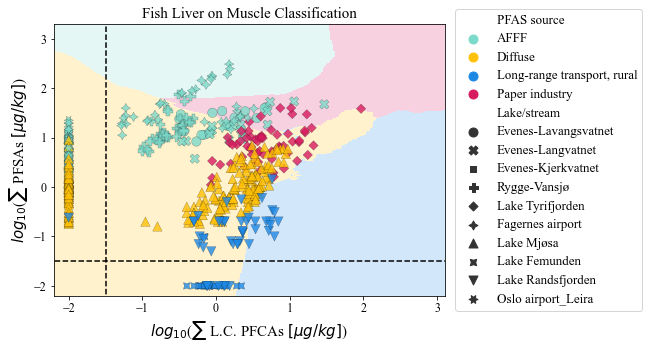

In [12]:
# Close plots at start of each block to prevent odd figure behavior
plt.close()
plt.rcParams['font.family'] = 'Times New Roman'
n_neighbors=8
knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights= 'uniform')
knn.fit(lX,ly)
acc = knn.score(lX, ly)
acc2 = knn.score(mX, my)

print("KNN accuracy for Liver data: " + str(round(acc,3)))
print("KNN Accuracy for muscle with Liver classifer: " + str(round(acc2, 3)))
h = 0.02  # number of steps in mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light

Mus['logPFCAs'] = mX[:,0]
Mus['logPFSAs'] = mX[:,1]

for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(lX, ly)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = -2.2, 3.1
    y_min, y_max = -2.2, 3.3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.2)

    # Plot also the training points
    # plt.scatter(lX[:, 0], lX[:, 1], c=ly, cmap=cmap_bold, marker='x')
    sns.scatterplot(data=Mus, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Fish Liver on Muscle Classification", fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
    # plt.tight_layout()
    
MDL = np.log10(0.0316)
plt.plot([MDL,MDL],[-5,5],'k--')
plt.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\KNN_LiverOnMuscle_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()

# Process Muscle Data now - KNN

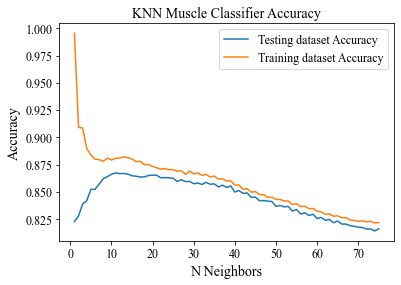

11


In [13]:
# Split into training and test set
 
totalK = 75
totalR = 50
neighbors = np.arange(1, totalK+1)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalK, totalR))
trains = np.zeros((totalK, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                mX, my, test_size = 0.2, random_state=j)
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(neighbors, testAvg, label = 'Testing dataset Accuracy')
plt.plot(neighbors, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('KNN Muscle Classifier Accuracy', fontsize = 14)
plt.xlabel('N Neighbors', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\KNN_muscle_calibration.png', dpi = 150, bbox_inches='tight')
plt.show()
print(testAvg.argmax()+1)

KNN accuracy for Muscle data: 0.882
KNN Accuracy for Liver with Muscle classifer: 0.35


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_22956\4144583558.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFCAs'] = mX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_22956\4144583558.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFSAs'] = mX[:,1]


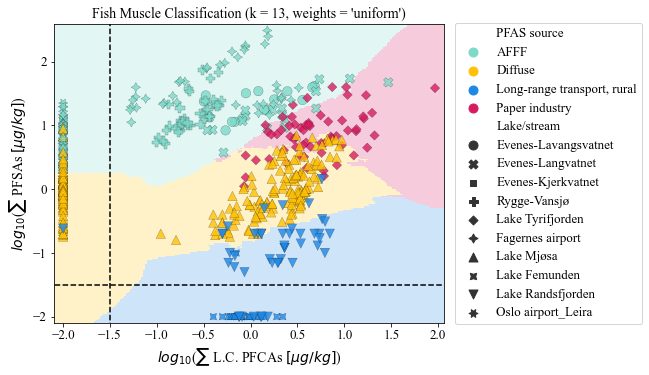

In [14]:
plt.close()
n_neighbors=13
knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights= 'uniform')
knn.fit(mX,my)
acc = knn.score(mX, my)
acc2 = knn.score(lX, ly)

print("KNN accuracy for Muscle data: " + str(round(acc,3)))
print("KNN Accuracy for Liver with Muscle classifer: " + str(round(acc2, 3)))
h = 0.02  # step size in the mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light

Mus['logPFCAs'] = mX[:,0]
Mus['logPFSAs'] = mX[:,1]


for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(mX, my)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = mX[:, 0].min() - .3, mX[:, 0].max() + .3
    y_min, y_max = mX[:, 1].min() - .3, mX[:, 1].max() + .3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5.5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)

    sns.scatterplot(data=Mus, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(x_min+0.2, x_max-0.2)
    plt.ylim(y_min+0.2, y_max-0.2)
    plt.title("Fish Muscle Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights), fontsize = 14)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
MDL = np.log10(0.0316)
plt.plot([MDL,MDL],[-5,5],'k--')
plt.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\KNN_Muscle_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()

KNN accuracy for Liver data: 0.91
KNN Accuracy for muscle with Liver classifer: 0.48


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_22956\2823792387.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFCAs'] = lX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_22956\2823792387.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFSAs'] = lX[:,1]


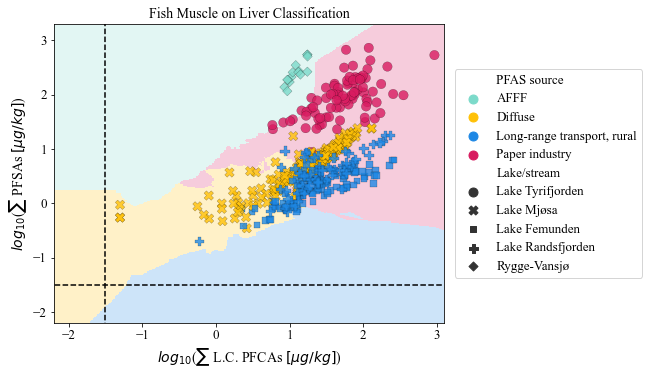

In [15]:
# Close plots at start of each block to prevent odd figure behavior
plt.close()
plt.rcParams['font.family'] = 'Times New Roman'
n_neighbors=8
knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights= 'uniform')
knn.fit(lX,ly)
acc = knn.score(lX, ly)
acc2 = knn.score(mX, my)

print("KNN accuracy for Liver data: " + str(round(acc,3)))
print("KNN Accuracy for muscle with Liver classifer: " + str(round(acc2, 3)))
h = 0.02  # number of steps in mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light

Liv['logPFCAs'] = lX[:,0]
Liv['logPFSAs'] = lX[:,1]

for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(mX, my)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = -2.2, 3.1
    y_min, y_max = -2.2, 3.3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5.5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)

    sns.scatterplot(data=Liv, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Fish Muscle on Liver Classification", fontsize = 14)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
MDL = np.log10(0.0316)
plt.plot([MDL,MDL],[-5,5],'k--')
plt.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\KNN_MuscleOnLiver_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()

# Try KNN of whole fish

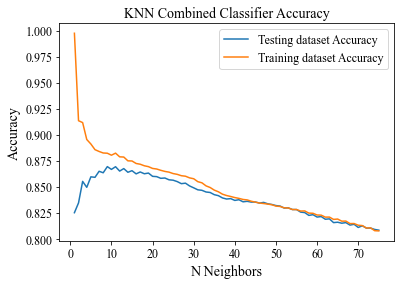

9


In [9]:
lDf = pd. read_excel('LangbergData.xlsx')
lDf.columns = lDf.iloc[0]
cols = lDf.columns.to_list()
lDf = lDf.drop(0, axis = 0)
lDf = lDf.drop(lDf.columns[[0,1,4,5,7,9,10]], axis=1)
lDf = lDf.replace(to_replace='<', value=0, regex=True)
lDf = lDf.fillna(0)

col1 = 'Sum LC-PFCA'
col2 = 'Sum PFSA'
lDf[col1] = lDf[['PFHpA','PFOA','PFNA','PFDA','PFUnDA','PFDoDA','PFTrDA','PFTeDA','PFPeDA']].sum(axis=1)
# lDf[col1] = lDf['PFUnDA']
lDf[col2] = lDf[['PFHxS','PFHpS','L-PFOS','Br-PFOS','PFDS']].sum(axis=1)
lDf = lDf[(lDf[col1] > 0) | (lDf[col2] > 0)]

lDf2 = lDf
lDf2[[col1,col2]] = lDf2[[col1,col2]].replace(0, 0.01)
# ---This is where log transform happens ---#
X = np.log10(lDf2[[col1, col2]].to_numpy())

lDf2['PFAS source'] = pd.Categorical(lDf2['PFAS source'])
lDf2['Categories'] = lDf2['PFAS source'].cat.codes
Sc = list(lDf['PFAS source'])

y = lDf2['Categories'].to_numpy()

# Split into training and test set
 
totalK = 75
totalR = 50
neighbors = np.arange(1, totalK+1)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalK, totalR))
trains = np.zeros((totalK, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = 0.2, random_state=j)
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(neighbors, testAvg, label = 'Testing dataset Accuracy')
plt.plot(neighbors, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('KNN Combined Classifier Accuracy', fontsize = 14)
plt.xlabel('N Neighbors', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\KNN_allData_calibration.png', dpi = 150)
plt.show()
print(testAvg.argmax()+1)

KNN accuracy for all data: 0.882


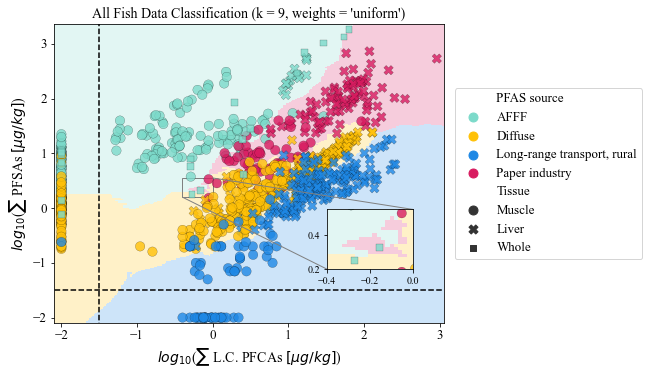

In [10]:
plt.close()
n_neighbors=9
knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights= 'uniform')
knn.fit(X,y)
acc = knn.score(X, y)

print("KNN accuracy for all data: " + str(round(acc,3)))

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light

lDf2['logPFCAs'] = X[:,0]
lDf2['logPFSAs'] = X[:,1]


for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .3, X[:, 0].max() + .3
    y_min, y_max = X[:, 1].min() - .3, X[:, 1].max() + .3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax1 = plt.subplots(figsize=(7,5.5))
    ax1.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)
    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax1, [0.7,0.18,0.22,0.2])
    ax2.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)
    sns.scatterplot(data=lDf2, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Tissue', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2, legend=False, ax=ax2)
    ax2.set_axes_locator(ip)
    ax2.set_xlim(-.4, 0.0)
    ax2.set_ylim(0.2, 0.55)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none", ec='0.5')

    sns.scatterplot(data=lDf2, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Tissue', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2, ax=ax1)
    ax1.set_xlim(x_min+0.2, x_max-0.2)
    ax1.set_ylim(y_min+0.2, y_max-0.2)
    ax1.set_title("All Fish Data Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights), fontsize = 14)
    ax1.set_xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.set_ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
MDL = np.log10(0.0316)
ax1.plot([MDL,MDL],[-5,5],'k--')
ax1.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\KNN_All_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()

KNN accuracy for all data: 0.882


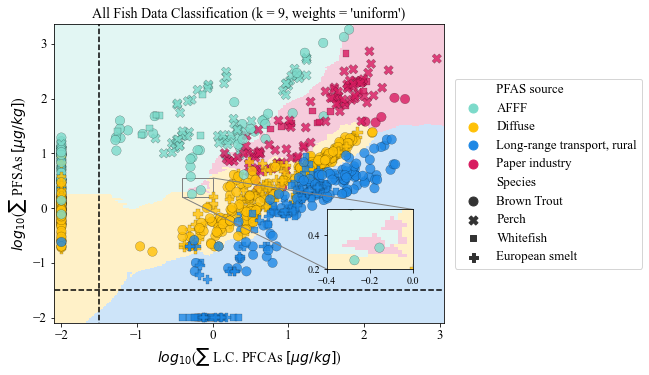

In [11]:
plt.close()
n_neighbors=9
knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights= 'uniform')
knn.fit(X,y)
acc = knn.score(X, y)

print("KNN accuracy for all data: " + str(round(acc,3)))

h = 0.02  # step size in the mesh
sp_l = ['Brown Trout', 'Perch', 'European smelt', 'Whitefish']
# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light

lDf2['logPFCAs'] = X[:,0]
lDf2['logPFSAs'] = X[:,1]
lDf2 = lDf2[lDf2['Species'].isin(sp_l)]

for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .3, X[:, 0].max() + .3
    y_min, y_max = X[:, 1].min() - .3, X[:, 1].max() + .3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax1 = plt.subplots(figsize=(7,5.5))
    ax1.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)
    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax1, [0.7,0.18,0.22,0.2])
    ax2.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)
    sns.scatterplot(data=lDf2, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Species', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2, legend=False, ax=ax2)
    ax2.set_axes_locator(ip)
    ax2.set_xlim(-.4, 0.0)
    ax2.set_ylim(0.2, 0.55)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none", ec='0.5')

    sns.scatterplot(data=lDf2, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Species', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2, ax=ax1)
    ax1.set_xlim(x_min+0.2, x_max-0.2)
    ax1.set_ylim(y_min+0.2, y_max-0.2)
    ax1.set_title("All Fish Data Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights), fontsize = 14)
    ax1.set_xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.set_ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
MDL = np.log10(0.0316)
ax1.plot([MDL,MDL],[-5,5],'k--')
ax1.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\KNN_All_resultsSpecies.png', bbox_inches = 'tight', dpi = 150)
plt.show()

# 4 class KNN with validation data

In [12]:
newMLdata = pd.read_excel("..\\otherData\\MLInput.xlsx")
newMLdata.head()

,Data Source,Location,Location ID,Source,Fish Species,Notes,n,Tissue,Sum LC PFCA,Sum PFSA,Log LC PFCA,Log PFSA,PFOS,PFUnDA,PFTrDA
0,Prickard 2022,New Hampshire,LOC 1,Suspect AFFF,Bluegill,NaN,1,Muscle,2.378800,3.282100,0.376358,0.516152,3.230200,0.665900,0.397300
1,Prickard 2022,New Hampshire,LOC 1,Suspect AFFF,Bluegill,NaN,1,Muscle,2.852453,4.135152,0.455219,0.616492,3.771798,0.732445,0.572572
2,Prickard 2022,New Hampshire,LOC 3,Suspect AFFF,Bluegill,NaN,1,Muscle,1.517000,5.479600,0.180986,0.738749,5.301900,0.531700,0.271900
3,Prickard 2022,New Hampshire,LOC 3,Suspect AFFF,Bluegill,NaN,1,Muscle,3.078555,21.368289,0.488347,1.329770,19.954533,0.000000,1.226363
4,Prickard 2022,New Hampshire,LOC 3,Suspect AFFF,Pumpkinseed,NaN,1,Muscle,1.358800,2.325100,0.133156,0.366442,2.253200,0.410900,0.331200


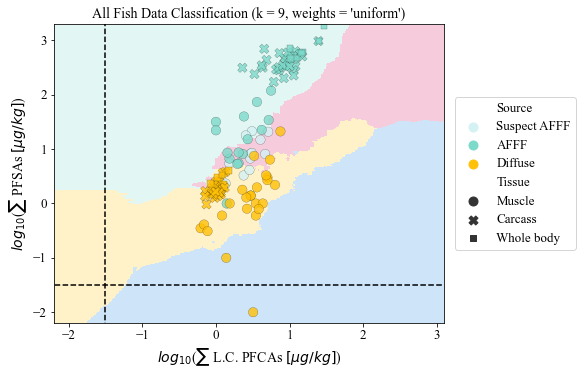

In [15]:
for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = -2.2, 3.1
    y_min, y_max = -2.2, 3.3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax1 = plt.subplots(figsize=(7,5.5))
    ax1.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)

    sns.scatterplot(data=newMLdata, x='Log LC PFCA', y = 'Log PFSA', hue = 'Source',  s= 90,
                    style= 'Tissue', palette= sns.color_palette(['#D4F1F4', '#7CDACA', '#FFC107']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2, ax=ax1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_title("All Fish Data Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights), fontsize = 14)
    ax1.set_xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.set_ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
MDL = np.log10(0.0316)
ax1.plot([MDL,MDL],[-5,5],'k--')
ax1.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('..\\otherData\\KNN_validation_4class.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [16]:
Xv = newMLdata[['Log LC PFCA', 'Log PFSA']].to_numpy()
yv = clf.predict(Xv)
finder = []
for i in list(yv):
    item = lDf2.loc[lDf2['Categories'] == i, 'PFAS source'].to_list()[0]
    finder.extend([item])

print(yv)
print(finder)
newMLdata['Source2'] = newMLdata['Source']
newMLdata.loc[newMLdata['Source2'] == 'Suspect AFFF', 'Source2'] = 'AFFF'
newMLdata['Predicted Source'] = finder
newMLdata['Correct'] = np.zeros(len(newMLdata.index))
for i in newMLdata.index:
    first = newMLdata.loc[i, 'Source2']
    second = newMLdata.loc[i, 'Predicted Source']
    if first == second:
        newMLdata.loc[i, 'Correct'] = 1
newMLdata['Weighted Correct'] = np.array(newMLdata['Correct'])*np.array(newMLdata['n'])

print("Total Prediction Accuracy: %s" % round(newMLdata['Weighted Correct'].sum()/newMLdata['n'].sum(), 2))
AFFF = newMLdata.loc[newMLdata['Source2'] == 'AFFF', 'Weighted Correct'].sum()/newMLdata.loc[newMLdata['Source2'] == 'AFFF','n'].sum()
Diff = newMLdata.loc[newMLdata['Source2'] == 'Diffuse', 'Weighted Correct'].sum()/newMLdata.loc[newMLdata['Source2'] == 'Diffuse','n'].sum()
print("Balanced Accuracy: %s" % round((AFFF+Diff)/2, 2))
print("AFFF Accuracy: %s" % round(AFFF,2))
print("Diffuse Accuracy: %s" % round(Diff,2))

newMLdata.to_excel('..\\otherData\\outputData.xlsx')

[1 1 1 0 1 3 3 3 3 0 3 3 3 3 3 3 0 3 3 2 1 1 3 3 3 1 0 0 0 3 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1
 1 1 1 3 1 1 1 1 1 1 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
['Diffuse', 'Diffuse', 'Diffuse', 'AFFF', 'Diffuse', 'Paper industry', 'Paper industry', 'Paper industry', 'Paper industry', 'AFFF', 'Paper industry', 'Paper industry', 'Paper industry', 'Paper industry', 'Paper industry', 'Paper industry', 'AFFF', 'Paper industry', 'Paper industry', 'Long-range transport, rural', 'Diffuse', 'Diffuse', 'Paper industry', 'Paper industry', 'Paper industry', 'Diffuse', 'AFFF', 'AFFF', 'AFFF', 'Paper industry', 'AFFF', 'AFFF', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Long-range transport, rural', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Dif

# Two class KNN validation

C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29024\973825242.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lDf3['PFAS source'] = pd.Categorical(lDf3['PFAS source'])
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29024\973825242.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lDf3['Categories'] = lDf3['PFAS source'].cat.codes


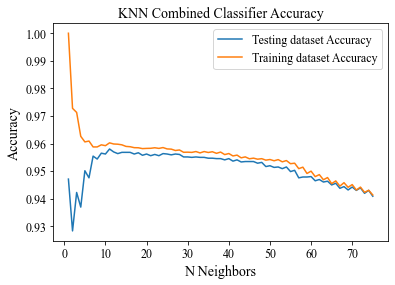

11


In [22]:
# First train the KNN algorithim with only two classes
lDf = pd. read_excel('LangbergData.xlsx')
lDf.columns = lDf.iloc[0]
cols = lDf.columns.to_list()
lDf = lDf.drop(0, axis = 0)
lDf = lDf.drop(lDf.columns[[0,1,4,5,7,9,10]], axis=1)
lDf = lDf.replace(to_replace='<', value=0, regex=True)
lDf = lDf.fillna(0)

col1 = 'Sum LC-PFCA'
col2 = 'Sum PFSA'
lDf[col1] = lDf[['PFHpA','PFOA','PFNA','PFDA','PFUnDA','PFDoDA','PFTrDA','PFTeDA','PFPeDA']].sum(axis=1)
# lDf[col1] = lDf['PFUnDA']
lDf[col2] = lDf[['PFHxS','PFHpS','L-PFOS','Br-PFOS','PFDS']].sum(axis=1)
lDf = lDf[(lDf[col1] > 0) | (lDf[col2] > 0)]

lDf2 = lDf
#  ----- THIS IS WHERE WE KEEP ONLY AFFF AND DIFFUSE DATA ---- #
lDf2[[col1,col2]] = lDf2[[col1,col2]].replace(0, 0.01)
lDf3 = lDf2[(lDf2['PFAS source'] == 'AFFF') | (lDf2['PFAS source'] == 'Diffuse')]
# ---This is where log transform happens ---#
X = np.log10(lDf3[[col1, col2]].to_numpy())

lDf3['PFAS source'] = pd.Categorical(lDf3['PFAS source'])
lDf3['Categories'] = lDf3['PFAS source'].cat.codes
Sc = list(lDf['PFAS source'])

y = lDf3['Categories'].to_numpy()

# Split into training and test set
 
totalK = 75
totalR = 50
neighbors = np.arange(1, totalK+1)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalK, totalR))
trains = np.zeros((totalK, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = 0.2, random_state=j)
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(neighbors, testAvg, label = 'Testing dataset Accuracy')
plt.plot(neighbors, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('KNN Combined Classifier Accuracy', fontsize = 14)
plt.xlabel('N Neighbors', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\KNN_2Class_allData_calibration.png', dpi = 150)
plt.show()
print(testAvg.argmax()+1)

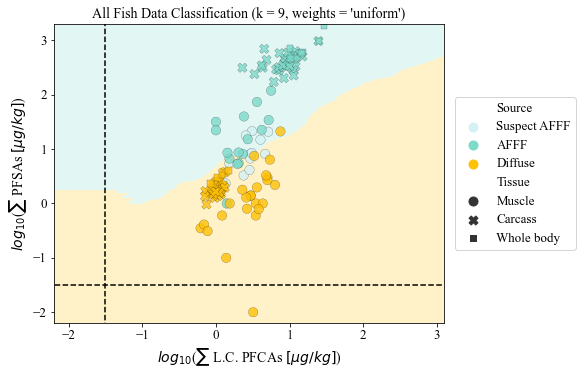

In [23]:
n_neighbors = 9
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107'])

for weights in ['uniform']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = -2.2, 3.1
    y_min, y_max = -2.2, 3.3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax1 = plt.subplots(figsize=(7,5.5))
    ax1.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)

    sns.scatterplot(data=newMLdata, x='Log LC PFCA', y = 'Log PFSA', hue = 'Source',  s= 90,
                    style= 'Tissue', palette= sns.color_palette(['#D4F1F4','#7CDACA', '#FFC107']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2, ax=ax1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_title("All Fish Data Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights), fontsize = 14)
    ax1.set_xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.set_ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
MDL = np.log10(0.0316)
ax1.plot([MDL,MDL],[-5,5],'k--')
ax1.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('..\\otherData\\KNN_validation_2class.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [25]:
Xv = newMLdata[['Log LC PFCA', 'Log PFSA']].to_numpy()
yv = clf.predict(Xv)
finder = []
for i in list(yv):
    item = lDf3.loc[lDf3['Categories'] == i, 'PFAS source'].to_list()[0]
    finder.extend([item])

print(yv)
print(finder)
newMLdata['Source2'] = newMLdata['Source']
newMLdata.loc[newMLdata['Source2'] == 'Suspect AFFF', 'Source2'] = 'AFFF'
newMLdata['Predicted Source'] = finder
newMLdata['Correct'] = np.zeros(len(newMLdata.index))
for i in newMLdata.index:
    first = newMLdata.loc[i, 'Source2']
    second = newMLdata.loc[i, 'Predicted Source']
    if first == second:
        newMLdata.loc[i, 'Correct'] = 1
newMLdata['Weighted Correct'] = np.array(newMLdata['Correct'])*np.array(newMLdata['n'])

print("Total Prediction Accuracy: %s" % round(newMLdata['Weighted Correct'].sum()/newMLdata['n'].sum(), 2))
AFFF = newMLdata.loc[newMLdata['Source2'] == 'AFFF', 'Weighted Correct'].sum()/newMLdata.loc[newMLdata['Source2'] == 'AFFF','n'].sum()
Diff = newMLdata.loc[newMLdata['Source2'] == 'Diffuse', 'Weighted Correct'].sum()/newMLdata.loc[newMLdata['Source2'] == 'Diffuse','n'].sum()
print("Balanced Accuracy: %s" % round((AFFF+Diff)/2, 2))
print("AFFF Accuracy: %s" % round(AFFF,2))
print("Diffuse Accuracy: %s" % round(Diff,2))

newMLdata.to_excel('..\\otherData\\outputData_2class.xlsx')

[1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
['Diffuse', 'Diffuse', 'Diffuse', 'AFFF', 'Diffuse', 'AFFF', 'Diffuse', 'Diffuse', 'AFFF', 'AFFF', 'AFFF', 'AFFF', 'Diffuse', 'Diffuse', 'AFFF', 'Diffuse', 'AFFF', 'AFFF', 'AFFF', 'Diffuse', 'Diffuse', 'Diffuse', 'AFFF', 'Diffuse', 'AFFF', 'Diffuse', 'AFFF', 'AFFF', 'AFFF', 'AFFF', 'AFFF', 'AFFF', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse', 'Diffuse',

# Start Support Vector Machine Classifier

In [26]:
#  Initialize calibration steps
# WARNING: this step takes approximately 10 minutes to run
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(lX, ly)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(lX, ly)
        classifiers.append((C, gamma, clf))

The best parameters are {'C': 100.0, 'gamma': 10.0} with a score of 0.91


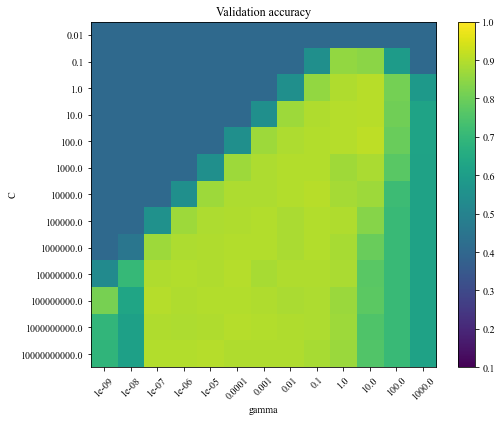

In [37]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.viridis,
    norm=MidpointNormalize(vmin=0.1, vmax =1.0, midpoint=0.55),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.savefig('images\\SVM_liver_calibration.png', dpi = 150)
plt.show()


SVM accuracy for Liver data: 0.894
-2.3010299956639813 3.9645586858457675


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29608\783691720.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFCAs'] = lX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29608\783691720.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFSAs'] = lX[:,1]


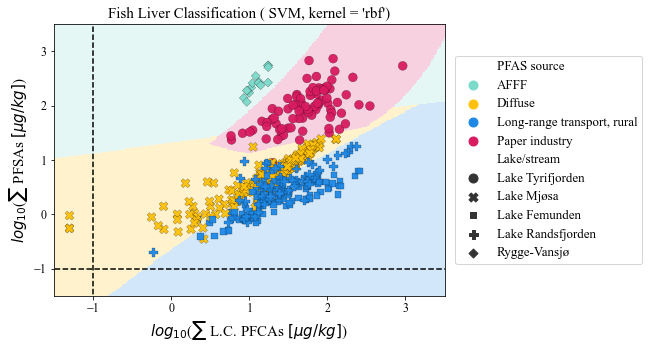

['liverPrediction_SVM.pkl']

In [38]:
plt.close()
plt.rcParams['font.family'] = 'Times New Roman'
svc = svm.SVC(kernel= 'rbf')
svc.fit(lX,ly)
acc = svc.score(lX, ly)

print("SVM accuracy for Liver data: " + str(round(acc,3)))
h = 0.02  # number of steps in mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light


Liv['logPFCAs'] = lX[:,0]
Liv['logPFSAs'] = lX[:,1]

for k in ['rbf']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = svm.SVC(kernel= k, C=10000, gamma=0.01)
    clf.fit(lX, ly)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = lX[:, 0].min() - 1, lX[:, 0].max() + 1
    y_min, y_max = lX[:, 1].min() - 1, lX[:, 1].max() + 1
    print(x_min, x_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.2)

    # Plot also the training points
    # plt.scatter(lX[:, 0], lX[:, 1], c=ly, cmap=cmap_bold, marker='x')
    sns.scatterplot(data=Liv, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 80,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.95, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(-1.5, 3.5)
    plt.ylim(-1.5, 3.5)
    plt.title("Fish Liver Classification ( %s, kernel = '%s')"
              % ('SVM', k), fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
    MDL = np.log10(0.1)
    plt.plot([MDL,MDL],[-5,5],'k--')
    plt.plot([-5,5], [MDL,MDL],'k--')
    # plt.tight_layout()
    
plt.savefig('images\\SVM_Liver_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()
joblib.dump(clf, 'liverPrediction_SVM.pkl')

In [39]:
#  New calibration
# WARNING: this step takes approximately 10 minutes to run
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(mX, my)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(mX, my)
        classifiers.append((C, gamma, clf))

The best parameters are {'C': 1000.0, 'gamma': 0.001} with a score of 0.88


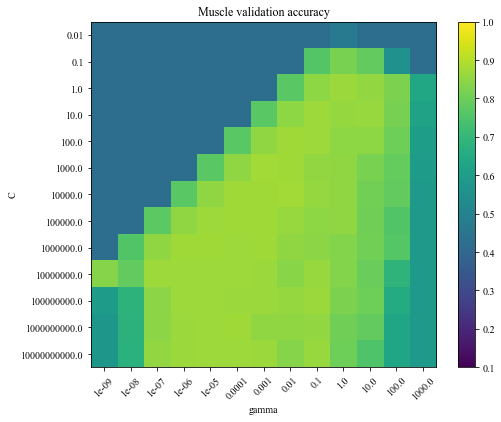

In [40]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.viridis,
    norm=MidpointNormalize(vmin=0.1, vmax =1.0, midpoint=0.55),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Muscle validation accuracy")
plt.savefig('images\\SVM_muscle_calibration.png', dpi = 150)
plt.show()


SVM accuracy for Muscle data: 0.871


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29608\2039598525.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFCAs'] = mX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_29608\2039598525.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFSAs'] = mX[:,1]


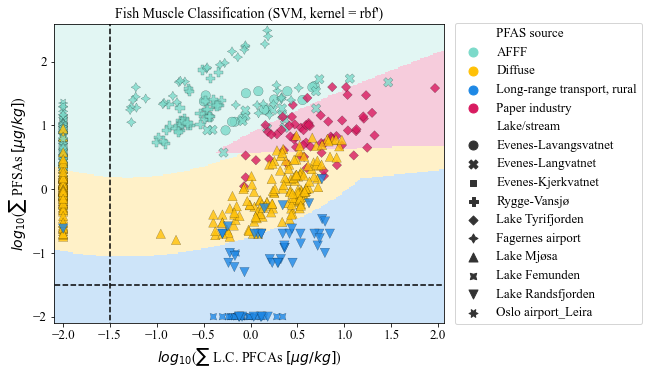

In [41]:
plt.close()
svc = svm.SVC( kernel= 'rbf')
svc.fit(mX,my)
acc = svc.score(mX, my)

print("SVM accuracy for Muscle data: " + str(round(acc,3)))

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light

Mus['logPFCAs'] = mX[:,0]
Mus['logPFSAs'] = mX[:,1]


for k in ['rbf']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = svm.SVC(kernel=k, C = 10000, gamma=.01)
    clf.fit(mX, my)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = mX[:, 0].min() - .3, mX[:, 0].max() + .3
    y_min, y_max = mX[:, 1].min() - .3, mX[:, 1].max() + .3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5.5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)

    sns.scatterplot(data=Mus, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(x_min+0.2, x_max-0.2)
    plt.ylim(y_min+0.2, y_max-0.2)
    plt.title("Fish Muscle Classification (%s, kernel = %s')"
              % ('SVM', k), fontsize = 14)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
    MDL = np.log10(0.0316)
    plt.plot([MDL,MDL],[-5,5],'k--')
    plt.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\SVM_Muscle_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [10]:
#  New calibration
# WARNING: this step takes approximately 10 minutes to run
# First train the KNN algorithim with only two classes
lDf = pd. read_excel('LangbergData.xlsx')
lDf.columns = lDf.iloc[0]
cols = lDf.columns.to_list()
lDf = lDf.drop(0, axis = 0)
lDf = lDf.drop(lDf.columns[[0,1,4,5,7,9,10]], axis=1)
lDf = lDf.replace(to_replace='<', value=0, regex=True)
lDf = lDf.fillna(0)

col1 = 'Sum LC-PFCA'
col2 = 'Sum PFSA'
lDf[col1] = lDf[['PFHpA','PFOA','PFNA','PFDA','PFUnDA','PFDoDA','PFTrDA','PFTeDA','PFPeDA']].sum(axis=1)
# lDf[col1] = lDf['PFUnDA']
lDf[col2] = lDf[['PFHxS','PFHpS','L-PFOS','Br-PFOS','PFDS']].sum(axis=1)
lDf = lDf[(lDf[col1] > 0) | (lDf[col2] > 0)]

lDf2 = lDf
#  ----- THIS IS WHERE WE KEEP ONLY AFFF AND DIFFUSE DATA ---- #
lDf2[[col1,col2]] = lDf2[[col1,col2]].replace(0, 0.01)
# ---This is where log transform happens ---#
X = np.log10(lDf2[[col1, col2]].to_numpy())

lDf2['PFAS source'] = pd.Categorical(lDf2['PFAS source'])
lDf2['Categories'] = lDf2['PFAS source'].cat.codes
Sc = list(lDf2['PFAS source'])

y = lDf2['Categories'].to_numpy()

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(X, y)
        classifiers.append((C, gamma, clf))

KeyboardInterrupt: 

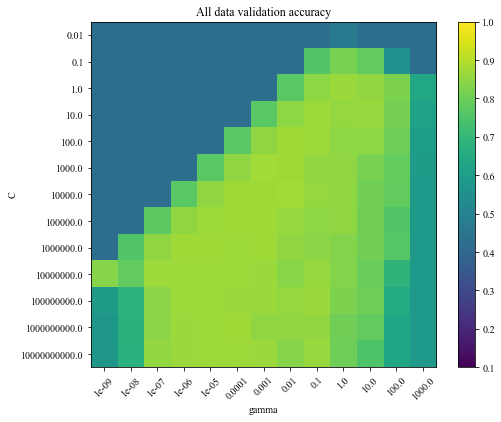

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.viridis,
    norm=MidpointNormalize(vmin=0.1, vmax =1.0, midpoint=0.55),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("All data validation accuracy")
plt.savefig('images\\SVM_allData_calibration.png', dpi = 150)
plt.show()


SVM accuracy for All data: 0.874


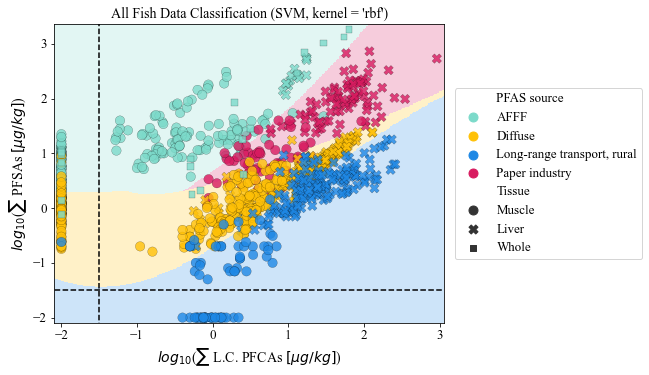

In [ ]:
plt.close()
svc = svm.SVC( kernel= 'rbf', C = 1.0)
svc.fit(X,y)
acc = svc.score(X, y)

print("SVM accuracy for All data: " + str(round(acc,3)))
# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light

lDf2['logPFCAs'] = X[:,0]
lDf2['logPFSAs'] = X[:,1]


for k in ['rbf']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = svm.SVC(kernel=k, C = 1000.0, gamma = 0.01)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .3, X[:, 0].max() + .3
    y_min, y_max = X[:, 1].min() - .3, X[:, 1].max() + .3
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5.5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.22)

    sns.scatterplot(data=lDf2, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 90,
                    style= 'Tissue', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.8, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(x_min+0.2, x_max-0.2)
    plt.ylim(y_min+0.2, y_max-0.2)
    plt.title("All Fish Data Classification (%s, kernel = '%s')"
              % ('SVM', k), fontsize = 14)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 14)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
MDL = np.log10(0.0316)
plt.plot([MDL,MDL],[-5,5],'k--')
plt.plot([-5,5], [MDL,MDL],'k--')
plt.savefig('images\\SVM_All_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()

# Repeat process with decision tree

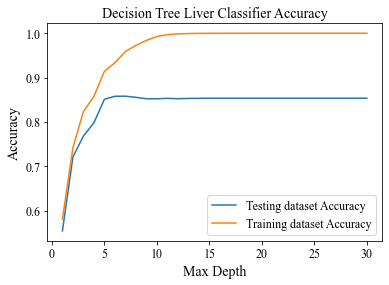

7


In [ ]:
totalD = 30
totalR = 50
depths = np.arange(1, totalD+1)
train_accuracy = np.empty(len(depths))
test_accuracy = np.empty(len(depths))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalD, totalR))
trains = np.zeros((totalD, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                lX, ly, test_size = 0.2, random_state=j)
    for i, k in enumerate(depths):
        tr = tree.DecisionTreeClassifier(random_state=j, max_depth=k)
        tr.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = tr.score(X_train, y_train)
        test_accuracy[i] = tr.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(depths, testAvg, label = 'Testing dataset Accuracy')
plt.plot(depths, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('Decision Tree Liver Classifier Accuracy', fontsize = 14)
plt.xlabel('Max Depth', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\TREE_liver_calibration.png', dpi = 150)
plt.show()
print(testAvg.argmax()+1)

Tree accuracy for Liver data: 0.956
-2.3010299956639813 3.9645586858457675


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_19544\2265701210.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFCAs'] = lX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_19544\2265701210.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Liv['logPFSAs'] = lX[:,1]


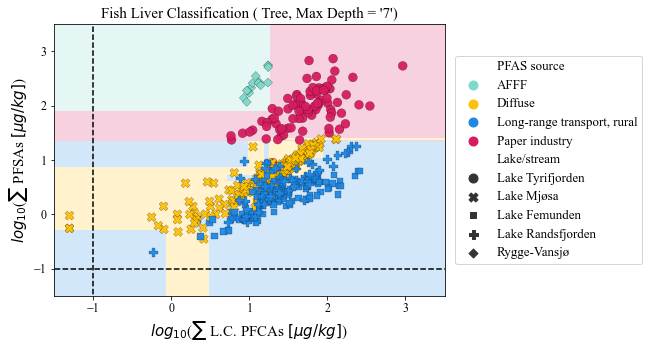

['liverPrediction_TREE.pkl']

In [15]:
plt.close()
plt.rcParams['font.family'] = 'Times New Roman'

md = 7
trC = tree.DecisionTreeClassifier(max_depth=7)
trC.fit(lX,ly)
acc = trC.score(lX, ly)

print("Tree accuracy for Liver data: " + str(round(acc,3)))
h = 0.02  # number of steps in mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light


Liv['logPFCAs'] = lX[:,0]
Liv['logPFSAs'] = lX[:,1]

for k in [md]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = tree.DecisionTreeClassifier(random_state=2, max_depth=k)
    clf.fit(lX, ly)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = lX[:, 0].min() - 1, lX[:, 0].max() + 1
    y_min, y_max = lX[:, 1].min() - 1, lX[:, 1].max() + 1
    print(x_min, x_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.2)

    # Plot also the training points
    # plt.scatter(lX[:, 0], lX[:, 1], c=ly, cmap=cmap_bold, marker='x')
    sns.scatterplot(data=Liv, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 80,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.95, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(-1.5, 3.5)
    plt.ylim(-1.5, 3.5)
    plt.title("Fish Liver Classification ( %s, Max Depth = '%i')"
              % ('Tree', k), fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
    MDL = np.log10(0.1)
    plt.plot([MDL,MDL],[-5,5],'k--')
    plt.plot([-5,5], [MDL,MDL],'k--')
    # plt.tight_layout()
    
plt.savefig('images\\TREE_Liver_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()
joblib.dump(clf, 'liverPrediction_TREE.pkl')

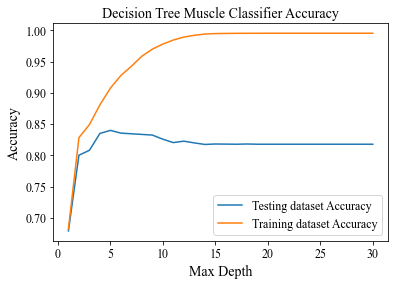

5


In [ ]:
totalD = 30
totalR = 50
depths = np.arange(1, totalD+1)
train_accuracy = np.empty(len(depths))
test_accuracy = np.empty(len(depths))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalD, totalR))
trains = np.zeros((totalD, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                mX, my, test_size = 0.2, random_state=j)
    for i, k in enumerate(depths):
        tr = tree.DecisionTreeClassifier(random_state=j, max_depth=k)
        tr.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = tr.score(X_train, y_train)
        test_accuracy[i] = tr.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(depths, testAvg, label = 'Testing dataset Accuracy')
plt.plot(depths, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('Decision Tree Muscle Classifier Accuracy', fontsize = 14)
plt.xlabel('Max Depth', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\TREE_muscle_calibration.png', dpi = 150)
plt.show()
print(testAvg.argmax()+1)

Tree accuracy for Muscle data: 0.923
-3.0 2.967229626542345


C:\Users\stultsjf\AppData\Local\Temp\ipykernel_19544\2747271470.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFCAs'] = mX[:,0]
C:\Users\stultsjf\AppData\Local\Temp\ipykernel_19544\2747271470.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mus['logPFSAs'] = mX[:,1]


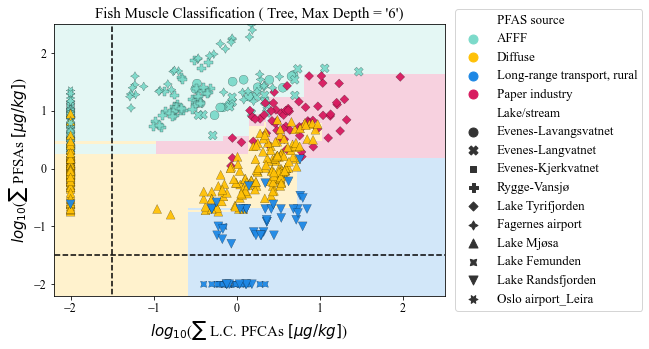

['musclePrediction_TREE.pkl']

In [16]:
plt.close()
plt.rcParams['font.family'] = 'Times New Roman'

md = 6
trC = tree.DecisionTreeClassifier(max_depth=6)
trC.fit(mX,my)
acc = trC.score(mX, my)

print("Tree accuracy for Muscle data: " + str(round(acc,3)))
h = 0.02  # number of steps in mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light


Mus['logPFCAs'] = mX[:,0]
Mus['logPFSAs'] = mX[:,1]

for k in [md]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = tree.DecisionTreeClassifier(random_state=2, max_depth=k)
    clf.fit(mX, my)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = mX[:, 0].min() - 1, mX[:, 0].max() + 1
    y_min, y_max = mX[:, 1].min() - 1, mX[:, 1].max() + 1
    print(x_min, x_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.2)

    # Plot also the training points
    # plt.scatter(lX[:, 0], lX[:, 1], c=ly, cmap=cmap_bold, marker='x')
    sns.scatterplot(data=Mus, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 80,
                    style= 'Lake/stream', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.95, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(-2.2, 2.5)
    plt.ylim(-2.2, 2.5)
    plt.title("Fish Muscle Classification ( %s, Max Depth = '%i')"
              % ('Tree', k), fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
    MDL = np.log10(0.0316)
    plt.plot([MDL,MDL],[-5,5],'k--')
    plt.plot([-5,5], [MDL,MDL],'k--')
    # plt.tight_layout()
    
plt.savefig('images\\TREE_Muscle_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()
joblib.dump(clf, 'musclePrediction_TREE.pkl')

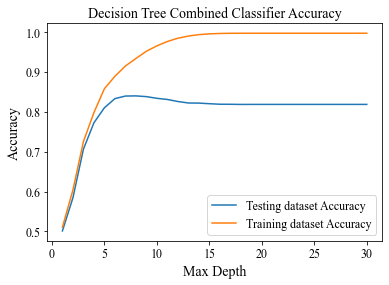

8


In [ ]:
totalD = 30
totalR = 50
depths = np.arange(1, totalD+1)
train_accuracy = np.empty(len(depths))
test_accuracy = np.empty(len(depths))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalD, totalR))
trains = np.zeros((totalD, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = 0.2, random_state=j)
    for i, k in enumerate(depths):
        tr = tree.DecisionTreeClassifier(random_state=j, max_depth=k)
        tr.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = tr.score(X_train, y_train)
        test_accuracy[i] = tr.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(depths, testAvg, label = 'Testing dataset Accuracy')
plt.plot(depths, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('Decision Tree Combined Classifier Accuracy', fontsize = 14)
plt.xlabel('Max Depth', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\TREE_allData_calibration.png', dpi = 150)
plt.show()
print(testAvg.argmax()+1)

Tree accuracy for all data: 0.914
-3.0 3.9645586858457675


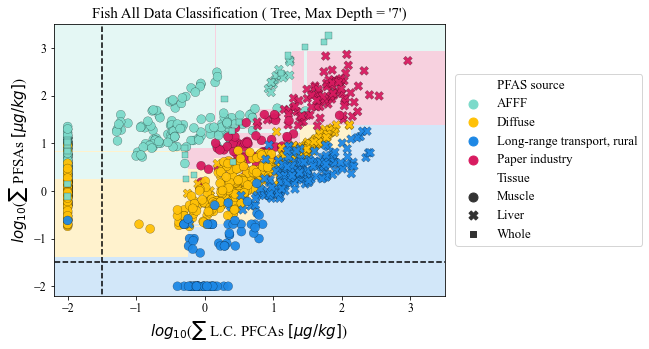

['allDataPrediction_TREE.pkl']

In [17]:
plt.close()
plt.rcParams['font.family'] = 'Times New Roman'

md = 7
trC = tree.DecisionTreeClassifier(max_depth=md)
trC.fit(X,y)
acc = trC.score(X, y)

print("Tree accuracy for all data: " + str(round(acc,3)))
h = 0.02  # number of steps in mesh

# Create color maps
cmap_light = colors.ListedColormap(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60'])
cmap_bold = cmap_light


lDf2['logPFCAs'] = X[:,0]
lDf2['logPFSAs'] = X[:,1]

for k in [md]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = tree.DecisionTreeClassifier(random_state=2, max_depth=k)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    print(x_min, x_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha = 0.2)

    # Plot also the training points
    # plt.scatter(lX[:, 0], lX[:, 1], c=ly, cmap=cmap_bold, marker='x')
    sns.scatterplot(data=lDf2, x='logPFCAs', y = 'logPFSAs', hue = 'PFAS source',  s= 80,
                    style= 'Tissue', palette= sns.color_palette(['#7CDACA', '#FFC107', '#1E88E5', '#D81B60']), alpha= 0.95, 
                    edgecolor='k', linewidth = 0.2)
    plt.xlim(-2.2, 3.5)
    plt.ylim(-2.2, 3.5)
    plt.title("Fish All Data Classification ( %s, Max Depth = '%i')"
              % ('Tree', k), fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.ylabel(r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(bbox_to_anchor = (1.01,0.5), loc = 'center left', fontsize = 13, markerscale = 1.5)
    MDL = np.log10(0.0316)
    plt.plot([MDL,MDL],[-5,5],'k--')
    plt.plot([-5,5], [MDL,MDL],'k--')
    # plt.tight_layout()
    
plt.savefig('images\\TREE_allData_results.png', bbox_inches = 'tight', dpi = 150)
plt.show()
joblib.dump(clf, 'allDataPrediction_TREE.pkl')

# Do the 5 parameter Model

In [23]:
cats1 = ['PFUnDA', 'PFTrDA', 'L-PFOS']
cats2 = ['PFUnDA', 'PFTrDA', 'L-PFOS','Tissue-Codes']

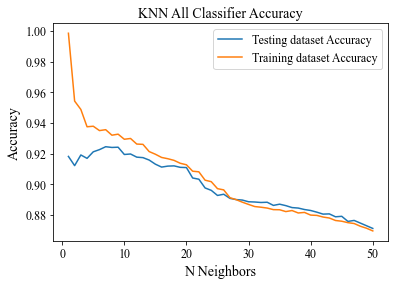

7


In [24]:
lDf = pd. read_excel('LangbergData.xlsx')
lDf.columns = lDf.iloc[0]
cols = lDf.columns.to_list()
lDf = lDf.drop(0, axis = 0)
lDf = lDf.drop(lDf.columns[[0,1,4,5,7,9,10]], axis=1)
lDf = lDf.replace(to_replace='<', value=0, regex=True)
lDf = lDf.fillna(0)
col1 = 'Sum LC-PFCA'
col2 = 'Sum PFSA'
lDf[col1] = lDf[['PFHpA','PFOA','PFNA','PFDA','PFUnDA','PFDoDA','PFTrDA','PFTeDA','PFPeDA']].sum(axis=1)
lDf[col2] = lDf[['PFHxS','PFHpS','L-PFOS','Br-PFOS','PFDS']].sum(axis=1)

lDf2 = lDf
lDf2['logCA'] = lDf[['PFHpA','PFOA','PFNA','PFDA','PFUnDA','PFDoDA','PFTrDA','PFTeDA','PFPeDA']].sum(axis=1)
# lDf[col1] = lDf['PFUnDA']
lDf2['logSA'] = lDf[['PFHxS','PFHpS','L-PFOS','Br-PFOS','PFDS']].sum(axis=1)
lDf2[cats1] = lDf2[cats1].replace(0, 0.01)
lDf2[['logCA','logSA']] = lDf2[['logCA','logSA']].replace(0, 0.01)
# ---This is where log transform happens ---#
lDf2['Tissue'] = pd.Categorical(lDf2['Tissue'])
lDf2['Tissue-Codes'] = lDf2['Tissue'].cat.codes
lDf2['Species'] = pd.Categorical(lDf2['Species'])
lDf2['Species-Codes'] = lDf2['Species'].cat.codes
lDf2[cats1] = np.log10(lDf2[cats1].to_numpy())
lDf2.head()
X2 = lDf2[cats2].to_numpy()

lDf2['logCA'] = np.log10(lDf2['logCA'].to_numpy())
lDf2['logSA'] = np.log10(lDf2['logSA'].to_numpy())


lDf2['PFAS source'] = pd.Categorical(lDf2['PFAS source'])
lDf2['Categories'] = lDf2['PFAS source'].cat.codes
Sc = list(lDf['PFAS source'])

y2 = lDf2['Categories'].to_numpy()

# Split into training and test set
 
totalK = 50
totalR = 30
neighbors = np.arange(1, totalK+1)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
rs = np.arange(1,totalR+1)

tests = np.zeros((totalK, totalR))
trains = np.zeros((totalK, totalR))
for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
                X2, y2, test_size = 0.2, random_state=j)
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_test, y_test)
    tests[:,j-1] = test_accuracy
    trains[:,j-1] = train_accuracy

testAvg = np.mean(tests, axis=1)
trainAvg = np.mean(trains, axis=1)
test95 = np.std(tests, axis = 1)*1.96/np.sqrt(totalR)
train95 = np.std(trains, axis = 1)*1.96/np.sqrt(totalR)
 
# Generate plot
plt.plot(neighbors, testAvg, label = 'Testing dataset Accuracy')
plt.plot(neighbors, trainAvg, label = 'Training dataset Accuracy')
 
plt.legend(fontsize = 12)
plt.title('KNN All Classifier Accuracy', fontsize = 14)
plt.xlabel('N Neighbors', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images\\KNN_5feature_calibration.png', dpi = 150)
plt.show()
print(testAvg.argmax()+1)


In [25]:
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X2, y2)
yP = clf.predict(X2)
lDf2['Predict Cat'] = yP
lDf2['Correct'] = y2-yP
print(lDf2['Correct'].drop_duplicates())
lDf2.loc[lDf2['Correct'] != 0, ['Correct']] = 'False'
lDf2.loc[lDf2['Correct'] == 0, ['Correct']] = 'True'

print(len(lDf2[lDf2['Correct'] == 0])/len(lDf2.index))
print(lDf2['Correct'].drop_duplicates())
print(lDf2['PFAS source'].drop_duplicates())
pd.DataFrame(X2).head()

1      0
4     -1
5     -3
131    3
135    2
421   -2
578    1
Name: Correct, dtype: int8
0.0
1     True
4    False
Name: Correct, dtype: object
1                             AFFF
91                  Paper industry
335                        Diffuse
359    Long-range transport, rural
Name: PFAS source, dtype: category
Categories (4, object): ['AFFF', 'Diffuse', 'Long-range transport, rural', 'Paper industry']


,0,1,2,3
0,-2.000000,-2.0,0.392697,1.0
1,-2.000000,-2.0,0.348305,1.0
2,0.170262,-2.0,1.245513,1.0
3,-2.000000,-2.0,-0.132533,1.0
4,-0.168130,-2.0,1.056905,1.0


In [26]:
lDf2.sample(10)


,PFAS source,Lake/stream,Species,Tissue,PFBA,PFPA,PFHxA,PFHpA,PFOA,PFNA,...,HPFHpA,Sum LC-PFCA,Sum PFSA,logCA,logSA,Tissue-Codes,Species-Codes,Categories,Predict Cat,Correct
736,Diffuse,Lake Mjøsa,Brown Trout,Muscle,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.839407,1.006865,-0.076027,0.002971,1,2,1,1,True
239,AFFF,Fagernes airport,Perch,Muscle,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.878200,170.508000,-0.056407,2.231745,1,5,0,0,True
930,"Long-range transport, rural",Lake Randsfjorden,Brown Trout,Liver,0.0,0.0,0.0,0.0,0.000000,0.700000,...,0.0,19.000000,3.400000,1.278754,0.531479,0,2,2,2,True
157,Paper industry,Lake Tyrifjorden,Brown Trout,Liver,0.0,0.0,0.0,0.0,0.000000,2.560000,...,0.0,350.200000,98.110000,2.544316,1.991713,0,2,3,3,True
690,Diffuse,Lake Mjøsa,European smelt,Muscle,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.240000,-2.000000,-0.619789,1,4,1,1,True
959,"Long-range transport, rural",Lake Randsfjorden,European smelt,Liver,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,15.600000,1.700000,1.193125,0.230449,0,4,2,2,True
881,"Long-range transport, rural",Lake Femunden,Whitefish,Muscle,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.620000,0.000000,-0.207608,-2.000000,1,10,2,2,True
305,AFFF,Fagernes airport,Perch,Muscle,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.931000,34.800000,0.285782,1.541579,1,5,0,0,True
628,Diffuse,Lake Mjøsa,European smelt,Muscle,0.0,0.0,0.0,0.0,1.121316,0.427109,...,0.0,3.270960,0.851413,0.514675,-0.069860,1,4,1,1,True
198,Paper industry,Lake Tyrifjorden,Perch,Muscle,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,3.889940,10.100000,0.589943,1.004321,1,5,3,3,True


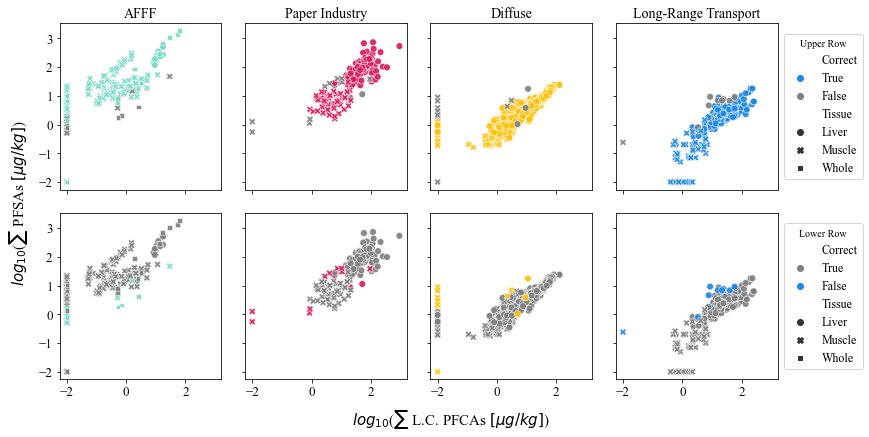

In [32]:
fig, axes = plt.subplots(2, 4, sharex= True, sharey = True, figsize=(12,6))
ax1 = axes[0,0] # Y axis labeled
ax2 = axes[0,1]
ax3 = axes[0,2]
ax4 = axes[0,3]
ax5 = axes[1,0] # Y axes labeles
ax6 = axes[1,1]
ax7 = axes[1,2]
ax8 = axes[1,3]
al = 0.92
# Correct AFFF
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'AFFF'], x = 'logCA', y = 'logSA', hue='Correct',
                palette=['#7CDACA','gray'], style='Tissue', alpha=al, ax=ax1, s = 45, legend=False)
# Incorect AFFF
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'AFFF'], x = 'logCA', y = 'logSA', hue='Correct',
                palette=['gray','#7CDACA'], style='Tissue', alpha=al, ax=ax5, s = 45,legend=False)

# Correct Paper Industry
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'Paper industry'], x = 'logCA', y = 'logSA', hue='Correct',
                palette=['#D81B60','gray'], style='Tissue', alpha=al, ax=ax2, s = 45, legend=False)
# Incorect Paper Industry
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'Paper industry'], x = 'logCA', y = 'logSA', hue='Correct',
                palette=['gray', '#D81B60'], style='Tissue', alpha=al, ax=ax6, s = 45, legend=False)

# Correct Diffuse 
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'Diffuse'].sort_values(by=['Correct'], ascending=False), x = 'logCA', y = 'logSA', hue='Correct',
                palette=[ '#FFC107','gray'], style='Tissue', alpha=al, ax=ax3, s = 45, legend=False)
# Incorect Diffuse
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'Diffuse'].sort_values(by=['Correct'], ascending=False), x = 'logCA', y = 'logSA', hue='Correct',
                palette=['gray', '#FFC107'], style='Tissue', alpha=al, ax=ax7, s = 45, legend=False)

# Correct Long Range Transport
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'Long-range transport, rural'], x = 'logCA', y = 'logSA', hue='Correct',
                palette=['#1E88E5','gray'], style='Tissue', alpha=al, ax=ax4, s = 45)
# Incorect Long Range Transport
sns.scatterplot(data=lDf2[lDf2['PFAS source'] == 'Long-range transport, rural'], x = 'logCA', y = 'logSA', hue='Correct',
                palette=['gray','#1E88E5'], style='Tissue', alpha=al, ax=ax8, s = 45)

ax1.set_ylabel('')
ax5.set_ylabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')
ax7.set_xlabel('')
ax8.set_xlabel('')
ax1.set_title('AFFF', fontsize=14)
ax2.set_title('Paper Industry', fontsize=14)

ax3.set_title('Diffuse', fontsize=14)
ax4.set_title('Long-Range Transport', fontsize=14)

ax1.tick_params(axis='y', labelsize=13)
ax5.tick_params(axis='x', labelsize=13)
ax5.tick_params(axis='y', labelsize=13)
ax6.tick_params(axis='x', labelsize=13)
ax7.tick_params(axis='x', labelsize=13)
ax8.tick_params(axis='x', labelsize=13)

ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Upper Row', fontsize = 12)
ax8.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Lower Row', fontsize = 12)

plt.tight_layout(pad = 2)

fig.text(0.5, 0., r'$log_{10}$($\sum$ L.C. PFCAs $\left[\mu g/kg \right]$)', ha='center', va = 'center', fontsize = 15,)
fig.text(0., 0.5, r'$log_{10}$($\sum$ PFSAs $\left[\mu g/kg \right]$)', ha='center', va = 'center', fontsize = 15, rotation = 'vertical')
plt.savefig('images\\confusionMatrix5Parameter.png', bbox_inches='tight', dpi=300)


In [33]:
# Now Calculate the balanced accuracy
AFFF = len(lDf2[(lDf2['PFAS source'] == 'AFFF') & (lDf2['Correct'] == 'True')])/len(lDf2[(lDf2['PFAS source'] == 'AFFF')])
Paper = len(lDf2[(lDf2['PFAS source'] == 'Paper industry') & (lDf2['Correct'] == 'True')])/len(lDf2[(lDf2['PFAS source'] == 'Paper industry')])
Diff = len(lDf2[(lDf2['PFAS source'] == 'Diffuse') & (lDf2['Correct'] == 'True')])/len(lDf2[(lDf2['PFAS source'] == 'Diffuse')])
Long = len(lDf2[(lDf2['PFAS source'] == 'Long-range transport, rural') & (lDf2['Correct'] == 'True')])/len(lDf2[(lDf2['PFAS source'] == 'Long-range transport, rural')])

print(AFFF, Paper, Diff, Long)

BA = np.mean([AFFF, Paper, Diff, Long])
print("Balanced Accuracy: " + str(round(BA, 3)))
print(len(lDf2[lDf2['Correct'] == 'True'].index)/len(lDf2.index))

0.9033613445378151 0.912751677852349 0.9648711943793911 0.941908713692946
Balanced Accuracy: 0.931
0.9383886255924171
